# Amortized Bayesian Inference of the Diffusion Model for Conflict Tasks

The Diffusion Model for Conflict Tasks (DMC; Ulrich et al., 2015) is an extension of the stationary Drift Diffusion Model (Ratcliff...) including a time-varying drift rate component and is able to account for reaction time dristributions and error rates in conflict tasks such as the Stroop task, Simon task or flanker task. In these tasks, a RT and error rate difference between congruent and incongruent trials is observed. That is, if some relevent dimension such as a target stimulus in the flanker task, is congruent with some irrelevant dimension (flanker stimuli), individual react faster and less error-prone than in conditions where both dimensions are congruent. The DMC has been shown to explain data better than a stationary DDM, especially regarding the trajectory of the congruency effect across the RTs (delta functions).



## Model Specification

Similar to a classic DDM, the DMC comprises a constant drift rate $\mu_c$. This route of evidence accumulation, also referred to as the controlled process is driven by the processing of relevant information such as the target stimulus in a flanker paradigm. Simultaneously, a second *automatic* drift process integrates irrelevant information such as the flanker stimuli in the flanker task. A second time-varying drift rate $\mu_a$ reflects this automatic activation at a given point in time $t$ formulated as a the derivative of a reshaped gamma function:

$$\mu_a(t) = \pm A \cdot e^{-t/\tau}\cdot \left[ \frac{t\cdot e}{(a-1)\cdot \tau}\right]^{a-1} \cdot \left[\frac{a - 1}{t}-\frac{1}{\tau}\right], a > 1$$

The sign of the amplitude A is defined by the congruency of relevant and irrelevant information. E.g. in a flanker task, the amplitude is positive if the flankers (irrelevant dimension) are similar to the target (relevenat information). Fore more information about the DMC architecture, see ...


Adding up both drift rate $\mu_c$ and $\mu_a$ results in the *superimposed* process, resembling the typically observed congruency effect in RTs and error rates.

In this notebook, we apply BayesFlow to the DMC to approximate Posteriors for the model parameters in an efficient, amortized way. Before starting, we load all packages and set the backend to pytorch:

In [104]:

import sys

sys.path.append("../../BayesFlow")
sys.path.append("../")

import os
import torch 

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import numpy as np
import pandas as pd
import pickle

import keras

import bayesflow as bf


We load the DMC simulator function and define some settings. DMC takes prior means and standard deviations as input arguments and simulates 200 observations (50% congruent, 50% incongruent trials) based on these priors. *sdr_fixed* denotes the exclusion of non-decision time variability. Choose *None* if you want to include this variability (as suggested in Schaefer et al., 2025). If doing so, make sure that the last value of prior_means and prior_sds as are specified and param_names includes "sd_r":

In [105]:
from dmc import DMC

param_names = ("A", "tau", "mu_c", "mu_r", "b", "sd_r")

simulator = DMC(prior_means=np.array([70.8, 114.71, 0.71, 332.34, 98.36, 43.36]),
                prior_sds=np.array([7.39, 41.9, 0.11, 23.96, 10.6, 8.27]),
                sdr_fixed=None,
                param_names=param_names,
                tmax=1500,
                contamination_probability=None,
                min_num_obs=50,
                max_num_obs=1000,
                fixed_num_obs=None)

Note that the maximum decision time is per default set to $1200 ms$ and the time discretization is set to $dt = 1 ms$. Setting $dt$ to lower values will result in a higher temporal resolution while prolonging the simulation time. $t_{max}$ should be chosen so that $\mu_r + t_{max}$ is higher than the maximum RT in the observed data. In order to account for longer RTs, we set  $t_{max}$ to 1500. We want the number of observations to be randomly drawn for each batch of data, so we set `fixed_num_obs` to `None` and define the minimum (`min_num_obs`) and maximum (`max_num_obs`) of possible trial numbers.

We test our simulator by simulating 1000 data sets. During the inference phase, one data set will include data from one individual. So this will simulate 1000 individuals:

In [106]:
test_data = simulator.sample(1000)

The *sample()* function produces a dictionary with the prior draws based on our prespecified prior distributions as well as the simulated RT and accuracy data and a vector *conditions* that indicate if the corresponding trial was simulated as a congruent trial (0) with a positive amplitude A or an incongruent trial (1) with a negative amplitude A.

In [107]:
for key, i in test_data.items():
    print(f'{key}: {i.shape}')


A: (1000, 1)
tau: (1000, 1)
mu_c: (1000, 1)
mu_r: (1000, 1)
sd_r: (1000, 1)
b: (1000, 1)
rt: (1000, 794, 1)
accuracy: (1000, 794, 1)
conditions: (1000, 794, 1)
num_obs: (1000, 1)


First, we inspect our prior distributions:

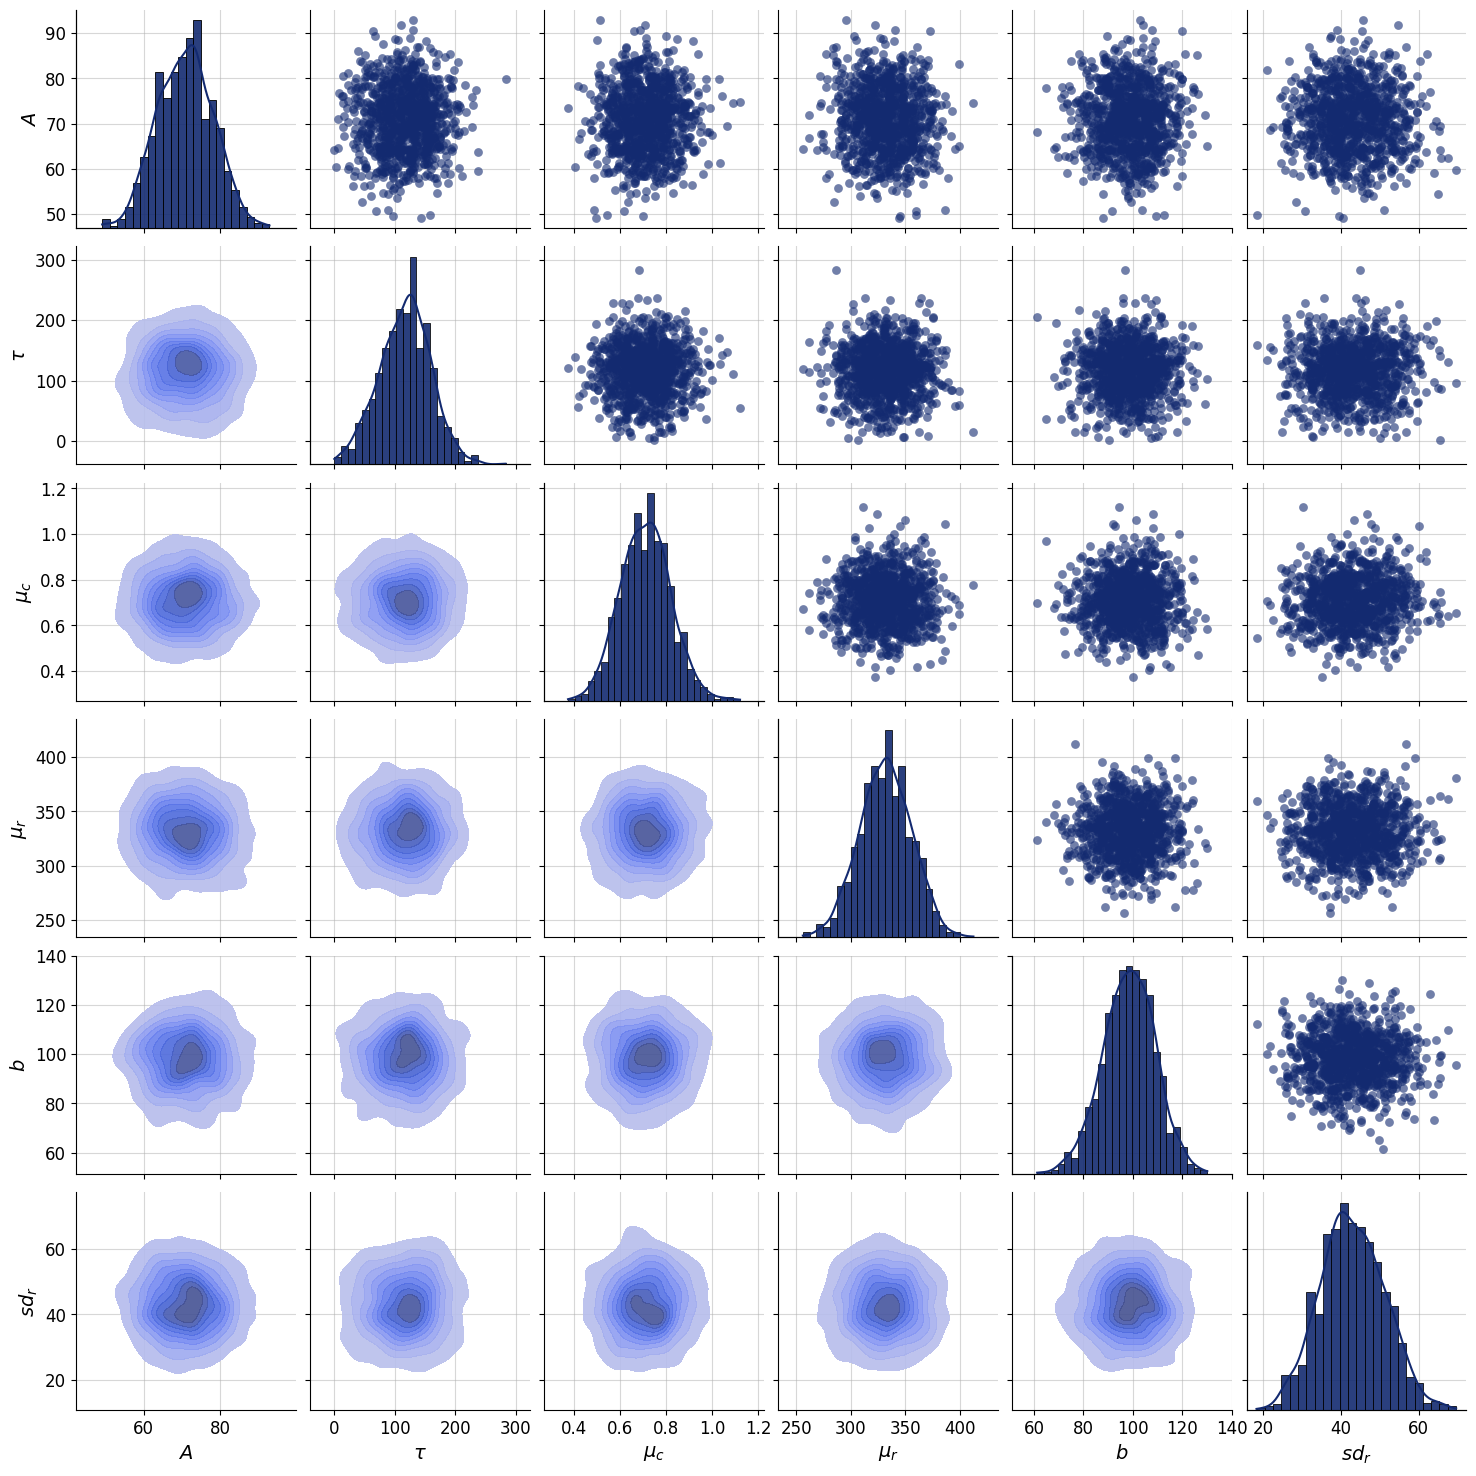

In [108]:
from dmc import param_labels

f = bf.diagnostics.plots.pairs_samples(
    samples=test_data,
    variable_keys=param_names,
    variable_names=param_labels(param_names)
)

The *sample()* function produces a dictionary with the prior draws based on our prespecified prior distributions as well as the simulated RT and accuracy data and a vector *conditions* that indicate if the corresponding trial was simulated as a congruent trial (0) with a positive amplitude A or an incongruent trial (1) with a negative amplitude A.

In [109]:
test_data = simulator.sample(10)

for key, i in test_data.items():
    print(f'{key}: {i.shape}')


A: (10, 1)
tau: (10, 1)
mu_c: (10, 1)
mu_r: (10, 1)
sd_r: (10, 1)
b: (10, 1)
rt: (10, 360, 1)
accuracy: (10, 360, 1)
conditions: (10, 360, 1)
num_obs: (10, 1)


Note that the shapes of the arrays in our dictionary vary between parameters and simulated data. Whereas for each simulated individual, we draw one set of parameters resulting in a shape (number of data sets, number of prior draws per data set) for each single parameter, the simulated data includes 200 observations for each data set, resulting in a shape of (number of data sets, number of observations, number of variables). The vector *num_obs* includes the number of observations which will later be necessary to inform the summary network.

Lets check if our RT distributions look as anticipated:

In [110]:
df = pd.DataFrame({k: test_data[k].flatten() for k in ['rt', 'accuracy', 'conditions']})
df

,rt,accuracy,conditions
0,0.709810,1.0,0
1,0.428929,1.0,0
2,0.388715,1.0,0
3,0.415727,1.0,0
4,0.748333,1.0,0
...,...,...,...
3595,0.527200,1.0,1
3596,0.458093,1.0,1
3597,0.764116,1.0,1
3598,0.584080,1.0,1


<Axes: xlabel='rt', ylabel='Density'>

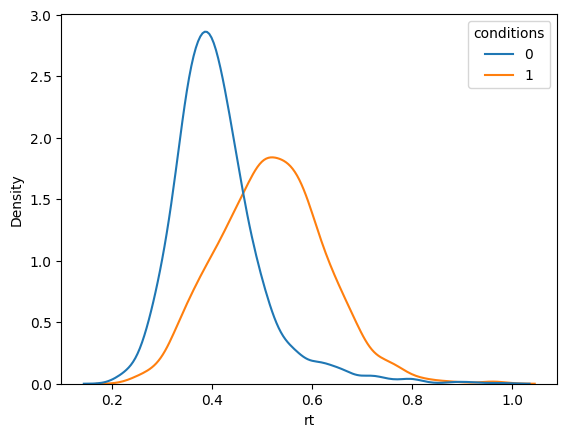

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(df, x = 'rt', hue='conditions')

Note that some observations include values of -1. This means that the diffusion process did not hit a boundary within the maximum time.

Our Priors as well as our simulated data looks as anticipated. We can now proceed with the interface between the simulated data and our neural networks. This is implemented as an *adapter*-function, ensuring that the networks get all data in the format they need:

In [112]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .sqrt("num_obs")
    .concatenate(param_names, into="inference_variables")
    .concatenate(["rt", "accuracy", "conditions"], into="summary_variables")
    .standardize(include="inference_variables")
    .rename("num_obs", "inference_conditions")
)


In our case, this means that everything is converted into `float32` data types, which is necessary for the networks to handle the data efficiently. Neural Network have generally problems processing large numbers, so we take the square root of our trial numbers ('num_obs'). We specify our 'inference_variables' which means that these variables indicate the parameters $\theta$ we want to approximate posteriors $p(\theta | y)$ for. The 'summary_variables' indicate the data that should be summarized by the summary network, so the inference network does not see the raw data but a summarized representation. 'inference_conditions' are additional information that the training is conditioned on, in our case the square root of the trial numbers. As mentioned before, large numbers can cause problems, so we z-standardize our inference variables. We can apply the adapter to our sampled data to check if everything is labelled and transformed correctly:

In [113]:
adapted_data = adapter(test_data)

for key, i in adapted_data.items():
    print(f'{key}: {i.shape}')


inference_variables: (10, 6)
summary_variables: (10, 360, 3)
inference_conditions: (10, 1)


We see that inference_variables include the 1000 parameter draws for each of the six parameters. The summary_variables include 1000 data sets with rt, accuracy and conditions for each of the 200 trials. In the inference_conditions, only 1 value - the number of trials - is stored per data set. 

We define the *summary network* as a set transformer and the *inference network* as flow matching:

In [114]:

inference_net = bf.networks.FlowMatching(coupling_kwargs=dict(subnet_kwargs=dict(dropout=0.011)))

summary_net = bf.networks.SetTransformer(dropout=0.011, num_seeds=7, summary_dim=22, embed_dim=(128, 128))


In the `workflow` object, we wrap everything up and define some settings for the training phase:

In [115]:
network_name = 'amortized_dmc'

workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    initial_learning_rate=0.00057,
    inference_network=inference_net,
    summary_network=summary_net,
    checkpoint_filepath='../data/training_checkpoints',
    checkpoint_name=network_name,
    inference_variables=param_names,
    save_best_only=True
)


By setting `save_best_only` to `True`, we ensure that the training epoch is only saved if the loss is lower then in the previous epoch. Make sure you specify a valid `checkpoint_filepath`. During the trianing phase, the training checkpoints are going to be stored there and can easily be loaded afterwards.

Before training the network, we simulate an independent sample of data that will later be used to assess potential overfit during the training phase. Since it is not included in the training routine, a larger loss with regards to this data set compared to the training data would indicate an overfit during training. However, since we are following a online training routine and apply multiple methods of regularization (weight decay, dropout and mini-batches), overfitting during the training routine is impossible.

In [116]:
val_data = simulator.sample(200)

Before starting the training, we have to specify, how long the training should last. The number of epochs indicate how many iterations are included in the training cycle. In each epoch, a specified number of batches will be simulated (`num_batches_per_epoch`) with each batch containing a specified numbers of data sets (`batch_size`). In our case, training will last 200 epochs, simulating 250 batches with 64 data sets in each epochs. All 64 data sets in one batch have the same randomly drawn number of trials.

In [91]:

history = workflow.fit_online(epochs=200, num_batches_per_epoch=250, batch_size=64, validation_data=val_data)


INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - loss: 14.4883 - loss/inference_loss: 14.4883

2025-06-26 14:07:30.068739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750939650.124017   95427 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750939650.141088   95427 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750939650.261456   95427 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750939650.261471   95427 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750939650.261472   95427 computation_placer.cc:177] computation placer alr

250/250 ━━━━━━━━━━━━━━━━━━━━ 245s 980ms/step - loss: 14.4476 - loss/inference_loss: 14.4476 - val_loss: 13.1782 - val_loss/inference_loss: 13.1782
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 238s 953ms/step - loss: 2.9835 - loss/inference_loss: 2.9835 - val_loss: 7.6677 - val_loss/inference_loss: 7.6677
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 240s 961ms/step - loss: 2.0772 - loss/inference_loss: 2.0772 - val_loss: 5.0338 - val_loss/inference_loss: 5.0338
Epoch 4/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 234s 935ms/step - loss: 1.7877 - loss/inference_loss: 1.7877 - val_loss: 4.5827 - val_loss/inference_loss: 4.5827
Epoch 5/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - loss: 1.6088 - loss/inference_loss: 1.6088 - val_loss: 3.1113 - val_loss/inference_loss: 3.1113
Epoch 6/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 235s 940ms/step - loss: 1.3845 - loss/inference_loss: 1.3845 - val_loss: 8.3288 - val_loss/inference_loss: 8.3288
Epoch 7/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 244s 978ms/step - loss: 1.2381 - loss/in

INFO:bayesflow:Training is now finished.
            You can find the trained approximator at '../data/training_checkpoints/amortized_dmc.amortized_dmc.keras'.
            To load it, use approximator = keras.saving.load_model(...).


After training, we can inspect the loss, hopefully seeing a smooth decline over the training epochs with no major jumps and an equal trajectory for the validation and training data sets.

In [118]:
figs = workflow.plot_default_diagnostics(test_data=val_data, variable_names=param_labels(param_names), calibration_ecdf_kwargs={'difference': True})


TypeError: normal(): argument 'size' failed to unpack the object at pos 3 with error "type must be tuple of ints,but got NoneType"